### MSDS 453 Final Project: Automated Text Summarization Using Transformer Model
#### Author: Rashmi Patel


#### Introduction
A Transformer model for text summarization follows the sequence-to-sequence (seq2seq) architecture:

Encoder: Processes the input text (e.g., a document).
Decoder: Generates the summarized text.
The Transformer uses:

Self-attention: To understand relationships within the input sequence.
Cross-attention: In the decoder, to align the generated sequence with the encoded representation.
Multi-head Attention: Captures dependencies across tokens.
Feedforward Neural Networks: Processes features extracted by attention mechanisms.
Positional Encoding: Adds positional information to the tokens since Transformers lack sequence information inherently.

positional_encoding:
Adds position information to token embeddings to maintain sequence order.
Uses sine and cosine functions for alternating dimensions.

create_padding_mask:
Masks out padding tokens (e.g., 0) in the input sequence.
Prevents the model from attending to meaningless positions.

create_look_ahead_mask:
Prevents the decoder from attending to future tokens.
Ensures causal sequence generation by masking tokens beyond the current position.

scaled_dot_product_attention:
Computes attention scores and outputs based on query (q), key (k), and value (v) inputs.
Optionally applies masks (e.g., padding mask or look-ahead mask).
Normalizes attention scores with softmax for weighted value computation.

get_angles:
Computes angles for generating positional encodings using sine and cosine functions.

#### Setting up the environment and loading libraries

In [165]:
# Importing packages 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [9]:
ENCODER_LEN = 100
DECODER_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8

## About Dataset:
<p>Meeting bank: It consists of 1,366 diverse meeting transcripts from six major U.S. cities.
Link: https://meetingbank.github.io/dataset/ </p>

<p>The Meeting Bank dataset serves as the primary source for this research, offering a varied set of structured and unstructured data. This study leverages the power of NLP and latest summarization techniques using transformers to apply the model on various transcripts to get condensed, meaningful summaries at the end. </p>


In [14]:
## Reading the Meeting bank data for training set
train = pd.read_csv("train.csv")
train.drop(['meeting_id', 'type', 'city'], axis=1, inplace=True)
train.head()

,source,reference
0,Speaker 4: Thank you. And can we do the functi...,Recommendation to increase appropriations in t...
1,Speaker 4: We're going to hear all of the pres...,Recommendation to conduct a Budget Hearing to ...
2,Speaker 4: Thank you very much. We will. We're...,Recommendation to declare ordinance amending t...
3,"Speaker 4: Great. Thank you. And, you know, we...",Recommendation to adopt resolution approving t...
4,Speaker 0: The motion is carried nine zero.\nS...,Recommendation to refer to the Public Health a...


In [15]:
train.info

<bound method DataFrame.info of                                                  source  \
0     Speaker 4: Thank you. And can we do the functi...   
1     Speaker 4: We're going to hear all of the pres...   
2     Speaker 4: Thank you very much. We will. We're...   
3     Speaker 4: Great. Thank you. And, you know, we...   
4     Speaker 0: The motion is carried nine zero.\nS...   
...                                                 ...   
5164  Speaker 0: Thank you. Docket 0965 will be plac...   
5165  Speaker 0: The docket has passed. Madam Clerk,...   
5166  Speaker 3: Docket 0481, the Committee on Gover...   
5167  Speaker 0: Nay. The ayes have it. The docket h...   
5168  Speaker 2: Madam Clerk, would you please read ...   

                                              reference  
0     Recommendation to increase appropriations in t...  
1     Recommendation to conduct a Budget Hearing to ...  
2     Recommendation to declare ordinance amending t...  
3     Recommendation to ado

In [16]:
## Reading the Meeting bank data for test set
test = pd.read_csv("test.csv")
test.drop(['meeting_id', 'type', 'city'], axis=1, inplace=True)
test.head()

,source,reference
0,Speaker 4: But why don't I just go through the...,Recommendation to request City Manager to work...
1,Speaker 1: And this is item 17. I joined 23 In...,Recommendation to receive supporting documenta...
2,Speaker 6: Councilman Zoro. I council member y...,Recommendation to request City Manager to work...
3,Speaker 1: We've done item 23. Next item is 20...,Recommendation to award a contract to Courtesy...
4,Speaker 0: That concludes public comment. So w...,Recommendation to direct City Manager to inves...


In [17]:
## Reading the Meeting bank data for validation set
val = pd.read_csv("val.csv")
val.drop(['meeting_id', 'type', 'city'], axis=1, inplace=True)
val.head()

,source,reference
0,Speaker 4: Thank you. And then we have our sec...,"Recommendation to authorize City Manager, or d..."
1,Speaker 0: Item 29 is a report from the City A...,Recommendation to adopt resolution of the City...
2,Speaker 4: Thank you. That concludes that item...,Recommendation to declare ordinance amending t...
3,Speaker 0: Item 25 is a report from technology...,Recommendation to adopt Specifications No. ITB...
4,Speaker 1: One Transfer Item 18 Communication ...,Recommendation to increase appropriations in t...


In [19]:
### Applying Start of the Sentence and End of Sentence tokens
maintext = train['source']
ref = train['reference']
maintext = maintext.apply(lambda x: '<SOS> ' + x + ' <EOS>')
ref = ref.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [20]:
### Preprocessing the text 
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
maintext = maintext.apply(lambda x: preprocess(x))
ref = ref.apply(lambda x: preprocess(x))

In [21]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
maintext_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
ref_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
maintext_tokenizer.fit_on_texts(maintext)
ref_tokenizer.fit_on_texts(ref)
inputs = maintext_tokenizer.texts_to_sequences(maintext)
targets = ref_tokenizer.texts_to_sequences(ref)

In [22]:
ENCODER_VOCAB = len(maintext_tokenizer.word_index) + 1
DECODER_VOCAB = len(ref_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

62804 12685


In [23]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<p>Two empty lists, maintext_token_counts and ref_token_counts, are created. The script iterates over each row of the train_df DataFrame using the iterrows() method. For each row, it calculates the number of tokens in the "source" and "reference" columns using the encode() method of the tokenizer object, appending the counts to the respective lists.</p>

In [164]:
maintext_token_counts = [len(tokenizer.encode(row["source"])) for _, row in train.iterrows()]
ref_token_counts = [len(tokenizer.encode(row["reference"])) for _, row in train.iterrows()]


Token indices sequence length is longer than the specified maximum sequence length for this model (851 > 512). Running this sequence through the model will result in indexing errors


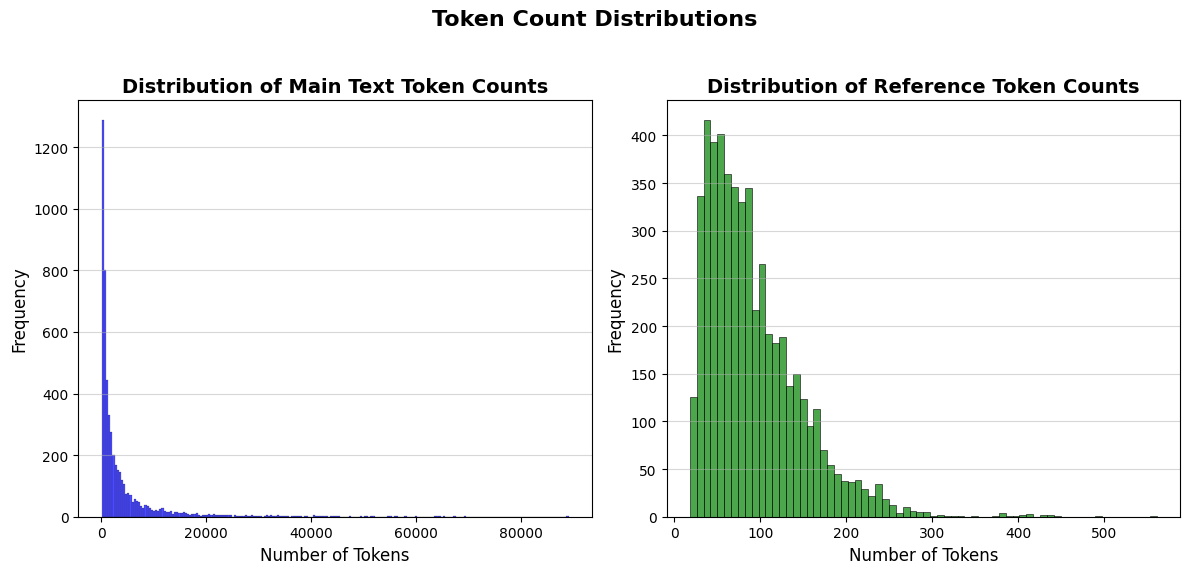

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(maintext_token_counts, ax=ax1, color='blue', alpha=0.7)
ax1.set_title("Distribution of Main Text Token Counts", fontsize=14, fontweight='bold')
ax1.set_xlabel("Number of Tokens", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.grid(axis='y', alpha=0.5)

sns.histplot(ref_token_counts, ax=ax2, color='green', alpha=0.7)
ax2.set_title("Distribution of Reference Token Counts", fontsize=14, fontweight='bold')
ax2.set_xlabel("Number of Tokens", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.grid(axis='y', alpha=0.5)

plt.suptitle("Token Count Distributions", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<b>The subsequent code blocks encompass the basic implementation of the Transformer model.</b>


In [25]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2


In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        return x, attention_weights

In [30]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [31]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 15

### Learning Rate and Customization

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [34]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

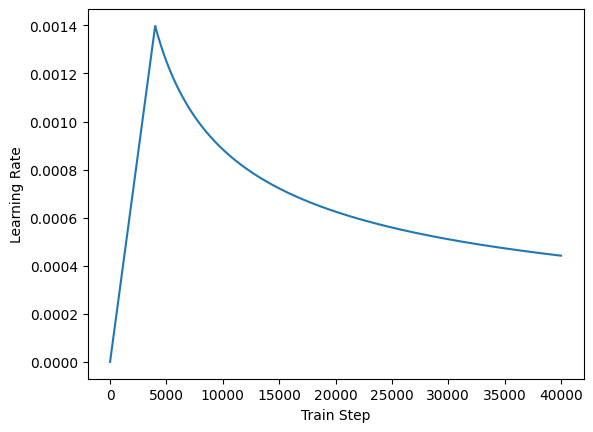

In [35]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Checking Loss and Accuracy

In [36]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [37]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [38]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [39]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [40]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [41]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

### Training the Model

In [162]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7996 Accuracy 0.2141
Epoch 1 Loss 3.1557 Accuracy 0.2299
Time taken for 1 epoch: 28.1668119430542 secs

Epoch 2 Batch 0 Loss 2.7125 Accuracy 0.2301
Epoch 2 Loss 2.9827 Accuracy 0.2452
Time taken for 1 epoch: 27.701714992523193 secs

Epoch 3 Batch 0 Loss 2.6103 Accuracy 0.2454
Epoch 3 Loss 2.8184 Accuracy 0.2600
Time taken for 1 epoch: 27.49302887916565 secs

Epoch 4 Batch 0 Loss 2.4253 Accuracy 0.2602
Epoch 4 Loss 2.6609 Accuracy 0.2742
Time taken for 1 epoch: 27.7584011554718 secs

Epoch 5 Batch 0 Loss 2.4447 Accuracy 0.2744
Saving checkpoint for epoch 5 at checkpoints/ckpt-4
Epoch 5 Loss 2.5138 Accuracy 0.2878
Time taken for 1 epoch: 28.99684190750122 secs

Epoch 6 Batch 0 Loss 2.1782 Accuracy 0.2880
Epoch 6 Loss 2.3752 Accuracy 0.3010
Time taken for 1 epoch: 27.54604196548462 secs

Epoch 7 Batch 0 Loss 2.2877 Accuracy 0.3012
Epoch 7 Loss 2.2344 Accuracy 0.3138
Time taken for 1 epoch: 27.458435773849487 secs

Epoch 8 Batch 0 Loss 2.0564 Accuracy 0.3139
Epoch 8 

### Evaluating the model:


In [167]:
def evaluate(input_transcript):
    input_transcript = maintext_tokenizer.texts_to_sequences([input_transcript])
    input_transcript = tf.keras.preprocessing.sequence.pad_sequences(input_transcript, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_transcript[0], 0)

    decoder_input = [ref_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == ref_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [168]:
def summarize(input_transcript):
    summarized = evaluate(input_transcript=input_transcript)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  
    return ref_tokenizer.sequences_to_texts(summarized)[0]

### Looking at some Summarizations:

In [169]:
maintext[10]

"<SOS> Speaker 3: Thank you. Number 23, please.\nSpeaker 0: Item 23 Report from Financial Management Recommendation to Adobe Resolution Authorizing City Manager to execute a contract with Home Depot USA for furnishing and delivering materials on an as needed basis, literally in a total annual amount and not to exceed 1.2 million.\nSpeaker 3: Thank you. Moving in second in any public comment on this.\nSpeaker 5: If there are any members of the public that would like to speak on item 23 in person, please line up at the podium in Zoom. Please use the raise hand feature. See. Now, that concludes public comments.\nSpeaker 3: Thank you, members. Please cast your vote.\nSpeaker 0: As Women's Sunday has.\nSpeaker 2: I.\nSpeaker 0: Councilwoman Allen. I can't. WOMAN Price.\nSpeaker 2: I.\nSpeaker 0: Councilman Spinner. Councilwoman Mango.\nSpeaker 2: Hi.\nSpeaker 0: Councilwoman Sara I Councilmember Ranga. Councilman Austin.\nSpeaker 6: Hi.\nSpeaker 0: Vice Mayor Richardson. The motion is 87 ze

In [170]:
print("\nPredicted Summary : ", summarize(maintext[10]))


Predicted Summary :  recommendation to adopt resolution authorizing city manager or designee to execute a contract and any necessary documents including any necessary


In [171]:
maintext[1212]

"<SOS> Speaker 1: Thank you. Back to item five of the consent calendar.\nSpeaker 2: Item Pfizer Report from Development Services Financial Management Recommendation two What the contract to KLA Corporation for Downtown Long Beach Area Parking study for total contract amount not to exceed $269,000 one and two.\nSpeaker 9: Councilmember Gonzalez Yes, I just had questions. We didn't you know, this item was really light. It didn't really include a lot of information. I know this is relative to the TAPS group. So can we get a staff report on this item and some more context around what exactly the boundaries, the scope of work, etc., please?\nSpeaker 5: Amy Bodak.\nSpeaker 3: Mr. Mayor. Members of the city council. Good morning. With this is a scope of work that was reviewed as part of the settlement agreement between TAPS and the city of Long Beach for three downtown projects. The settlement agreement was very specific on what the survey areas would be in the scope of work, and an RFP was d

In [172]:
print("\nPredicted Summary : ", summarize(maintext[1212]))


Predicted Summary :  recommendation to adopt specifications no rfp ep16 121 for the purchase and development opportunity at alameda point base reuse 819099
